In [1]:
import yaeos
from yaeos import PengRobinson76, QMR
import numpy as np

In [2]:
# Number of components, for easier definition
nc = 2

# kij and lij matrices
k12 = 0.1
lij = kij = np.zeros((nc,nc))
kij[0,1] = kij[1,0] = k12

mixrule = QMR(kij, lij)

# Critical constants
Tc = [320, 375]
Pc = [30, 45]
w = [0.0123, 0.045]

model = PengRobinson76(Tc, Pc, w, mixrule)
n = [1.0, 0.2]

model.fugacity(n, v=2.0, t=303.15, dn=True)

{'ln_phi': array([2.3118468 , 2.33292475]),
 'dt': None,
 'dp': None,
 'dn': array([[-0.00186921,  0.00934604],
        [ 0.00934604, -0.04673019]])}

In [3]:
n = [0.4, 0.6]
Tc = [190.564, 425.12]
Pc = [45.99, 37.96]
w = [0.0115478, 0.200164]

lij = kij = np.zeros((nc,nc))
mixrule = QMR(kij, lij)
model = PengRobinson76(Tc, Pc, w, mixrule)

In [4]:
%%time
P, T = 60.0, 294.0

ts = np.linspace(200, 400, 50)
ps = np.linspace(30, 100, 50)
betas = []

t = []
p = []

for T in ts:
    for P in ps:
        flash = model.flash_tp(n, T, P)
        x = flash["x"]
        y = flash["y"]
        P = flash["P"]
        T = flash["T"]
        beta = flash["beta"]
        # x, y, P, T, Vx, Vy, beta = yaeos.yaeos_c.flash(id=model.id, z=n, p=P, t=T)
        t.append(T)
        p.append(P)
        betas.append(beta)

CPU times: user 706 ms, sys: 0 ns, total: 706 ms
Wall time: 704 ms


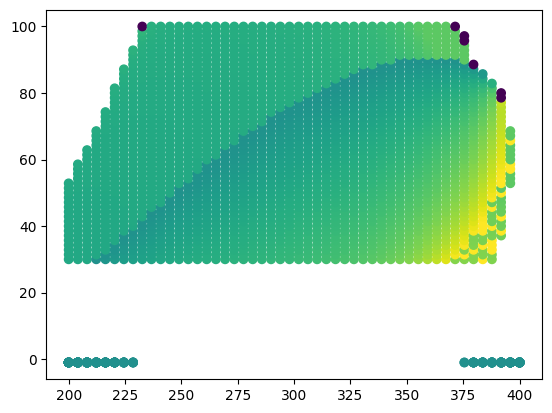

In [5]:
import matplotlib.pyplot as plt
plt.scatter(t, p, c=betas)

## Modified Huron-Vidal MixingRule

0.3388819694519043
0.42250776290893555
0.49509143829345703
0.5394766330718994
0.5379073619842529
0.5779635906219482
0.6288595199584961
0.6581037044525146
0.6781682968139648
CPU times: user 4.9 s, sys: 5.1 ms, total: 4.9 s
Wall time: 4.9 s


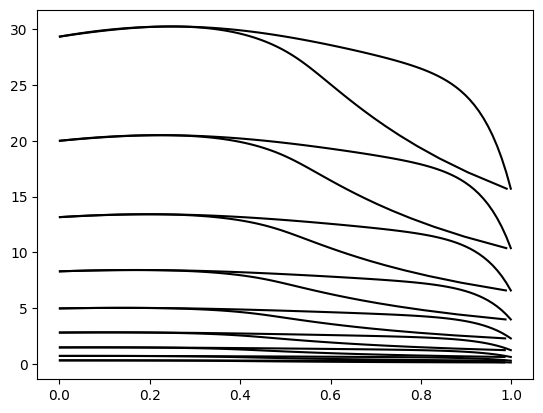

In [9]:
%%time
from yaeos import NRTL, MHV, PengRobinson76, yaeos_c
import numpy as np
import matplotlib.pyplot as plt

nc = 2
tc = [647.14, 513.92]
pc = [220.64, 61.48]
w =  [0.344, 0.649]

a = [[0, 3.458], [-0.801, 0]]
b = [[0, -586.1], [246.2, 0]]
c = [[0, 0.3], [0.3, 0]]

b = np.array(b)

ge_model = NRTL(a, b, c)
mixrule = MHV(ge_model, q=-0.53)
model = PengRobinson76(tc, pc, w, mixrule)


colors = ["red", "green", "blue", "orange", "black"]
ts = np.linspace(50+273, 200+273, 9)
import time
for i, T in enumerate(ts):
    i=4
    xs = np.linspace(0.001, 0.999, 100)
    ys = []
    ps = []

    st = time.time()
    
    for x1 in xs:
        x = [x1, 1-x1]
        sat = model.saturation_pressure(x, T, "bubble")
        p, y = sat["P"], sat["y"]
        ps.append(p)
        ys.append(y[0])

    print(time.time() - st)

    plt.plot(xs, ps, color=colors[i])
    plt.plot(ys, ps, color=colors[i])